# Build a DNN using the Keras Functional API




## Learning objectives

1. Review how to read in CSV file data using tf.data.
2. Specify input, hidden, and output layers in the DNN architecture.
3. Review and visualize the final DNN shape.
4. Train the model locally and visualize the loss curves.
5. Deploy and predict with the model using Cloud AI Platform. 


## Introduction

In this notebook, we will build a Keras DNN to predict the fare amount for NYC taxi cab rides.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/neural_network.ipynb).

In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
!sudo apt-get install graphviz -y # This command installs Graphviz, a tool for creating graph diagrams.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-liberation libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin libgvc6
  libgvpr2 liblab-gamut1 libpathplan4
Suggested packages:
  gsfonts graphviz-doc
The following NEW packages will be installed:
  fonts-liberation graphviz libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin
  libgvc6 libgvpr2 liblab-gamut1 libpathplan4
0 upgraded, 11 newly installed, 0 to remove and 2 not upgraded.
Need to get 3032 kB of archives.
After this operation, 11.5 MB of additional disk space will be used.
Get:1 https://deb.debian.org/debian bullseye/main amd64 fonts-liberation all 1:1.07.4-11 [828 kB]
Get:2 https://deb.debian.org/debian bullseye/main amd64 libann0 amd64 1.1.2+doc-7 [25.3 kB]
Get:3 https://deb.debian.org/debian bullseye/main amd64 libcdt5 amd64 2.42.2-5 [62.2 kB]
Get:4 https://deb.debian.org/debian bullseye/main amd64 libcgraph6 amd64 2.

In [4]:
# This library provides functions to interact with the operating system.
# This library allows working with JSON files. (e.g., json)
# This library (math) provides basic mathematical functions.
import os, json, math 

import numpy as np # Numpy is a fundamental library for scientific computing in Python.
import shutil # This library provides high-level operations with files and file collections.
import tensorflow as tf # TensorFlow is a popular library for machine learning and neural networks.
print("TensorFlow version: ",tf.version.VERSION) # This prints the version of TensorFlow that is installed.

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # SET TF ERROR LOG VERBOSITY

TensorFlow version:  2.11.0


## Locating the CSV files

We will start with the CSV files that we wrote out in the other notebook. Just so you don't have to run the notebook, we saved a copy in ../data/toy_data

In [5]:
!ls -l ../data/toy_data/*.csv 

-rw-r--r-- 1 jupyter jupyter 1111933 Jun 13 15:37 ../data/toy_data/taxi-traffic-test_toy.csv
-rw-r--r-- 1 jupyter jupyter 4772181 Jun 13 15:37 ../data/toy_data/taxi-traffic-train_toy.csv
-rw-r--r-- 1 jupyter jupyter 1038564 Jun 13 15:37 ../data/toy_data/taxi-traffic-valid_toy.csv


## Lab Task 1: Use tf.data to read the CSV files


First let's define our columns of data, which column we're predicting for, and the default values.

In [6]:
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key'] # This line defines a list called CSV_COLUMNS containing the column names of a CSV file.
LABEL_COLUMN = 'fare_amount' # This line defines the variable LABEL_COLUMN which contains the name of the column to be used as the label (or target) in the machine learning model.

DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']] # This line defines a list of lists called DEFAULTS, which contains the default values for each of the CSV columns in case of missing data.

Next, let's define our features we want to use and our label(s) and then load in the dataset for training.

In [8]:
# Create dataset from CSV files
def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key']:
        row_data.pop(unwanted_col) # Delete unwanted columns
    label = row_data.pop(LABEL_COLUMN) # Label is removed from "row_data" using pop() with LABEL_COLUMN ("fare_amount'")
    return row_data, label  # Return features and tag

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, # Used to create a dataset from CSV files matching the specified pattern (pattern)
                                                   batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # This separates the features from the label.
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

## Lab Task 2: Build a DNN with Keras

Now let's build the Deep Neural Network (DNN) model in Keras and specify the input and hidden layers. We will print out the DNN architecture and then visualize it later on.

In [9]:
## Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    INPUT_COLS = ['pickup_longitude', 'pickup_latitude', 
                  'dropoff_longitude', 'dropoff_latitude', 
                  'passenger_count'] # These are inputs that will be used to predict the cab fare.


    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in INPUT_COLS
    } # A dictionary of input layers is created where each entry is an "Input" layer corresponding to each input column.
    
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in INPUT_COLS
    } # A dictionary of numeric feature columns is created. These columns will be used to transform the entries into features usable by the network.
    
    
    # The constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    # "DenseFeatures" Used to create a layer that transforms the feature columns into a dense representation that can be fed to the neural network.
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    # The output layer has one unit (since we are predicting a single value: "fare_amount") and uses linear activation because it is a regression problem.
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    
    # The model is compiled with the "adam" optimizer and the "mse" (Mean Squared Error) is specified as the loss function.
    # In addition, "rmse" and "mse" are included as metrics to evaluate the model performance.
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary()) # A summary of the model architecture is built and printed.

Here is our DNN architecture so far:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dropoff_latitude (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 dropoff_longitude (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 passenger_count (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pickup_latitude (InputLayer)   [(None,)]            0           []                               
                                                        

## Lab Task 3: Visualize the DNN

We can visualize the DNN using the Keras [plot_model](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/utils/plot_model) utility.

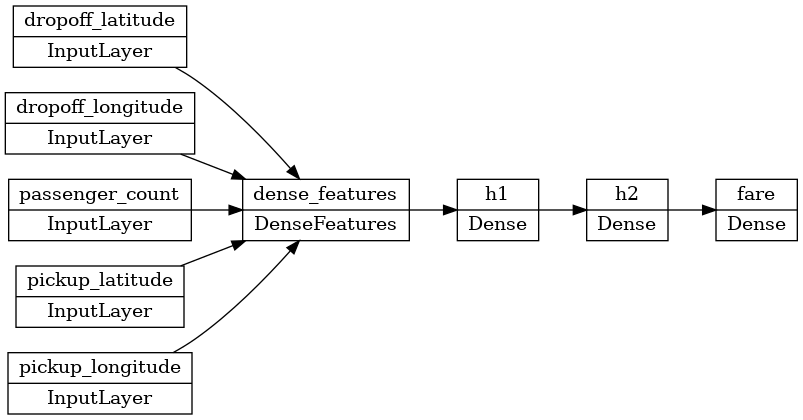

In [10]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Lab Task 4: Train the model

To train the model, simply call [model.fit()](https://keras.io/models/model/#fit).

Note that we should really use many more NUM_TRAIN_EXAMPLES (i.e. a larger dataset). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

In [11]:
TRAIN_BATCH_SIZE = 32 # Training batch size.
NUM_TRAIN_EXAMPLES = 10000 * 5 # Total number of training examples.
NUM_EVALS = 32  # Number of epochs or evaluations.
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

# Training dataset loaded from files matching "taxi-traffic-train" pattern and using a batch size of 32
trainds = load_dataset('../data/toy_data/taxi-traffic-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
# Evaluation dataset loaded from files matching the taxi-traffic-valid* pattern and using a batch size of 1000.
evalds = load_dataset('../data/toy_data/taxi-traffic-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

# This calculates how many steps per epoch are necessary.
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, # Training dataset that is passed to the "fit" method.
                    validation_data=evalds, # Validation dataset used to evaluate the model at the end of each epoch.
                    epochs=NUM_EVALS, # Number of training epochs, specified by "NUM_EVALS".
                    steps_per_epoch=steps_per_epoch) # Number of steps per epoch, previously calculated.

Epoch 1/32
48/48 [==============================] - 3s 24ms/step - loss: 311.2683 - rmse: 15.5356 - mse: 311.2683 - val_loss: 87.7646 - val_rmse: 9.3491 - val_mse: 87.7646
Epoch 2/32
48/48 [==============================] - 1s 11ms/step - loss: 94.2518 - rmse: 9.3046 - mse: 94.2518 - val_loss: 85.6764 - val_rmse: 9.2395 - val_mse: 85.6764
Epoch 3/32
48/48 [==============================] - 1s 11ms/step - loss: 112.5564 - rmse: 9.8607 - mse: 112.5564 - val_loss: 84.6042 - val_rmse: 9.1617 - val_mse: 84.6042
Epoch 4/32
48/48 [==============================] - 1s 12ms/step - loss: 87.6566 - rmse: 8.9146 - mse: 87.6566 - val_loss: 84.4776 - val_rmse: 9.1771 - val_mse: 84.4776
Epoch 5/32
48/48 [==============================] - 1s 12ms/step - loss: 80.1968 - rmse: 8.5877 - mse: 80.1968 - val_loss: 89.3158 - val_rmse: 9.4282 - val_mse: 89.3158
Epoch 6/32
48/48 [==============================] - 1s 11ms/step - loss: 79.6490 - rmse: 8.4564 - mse: 79.6490 - val_loss: 91.6551 - val_rmse: 9.5653 

### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.

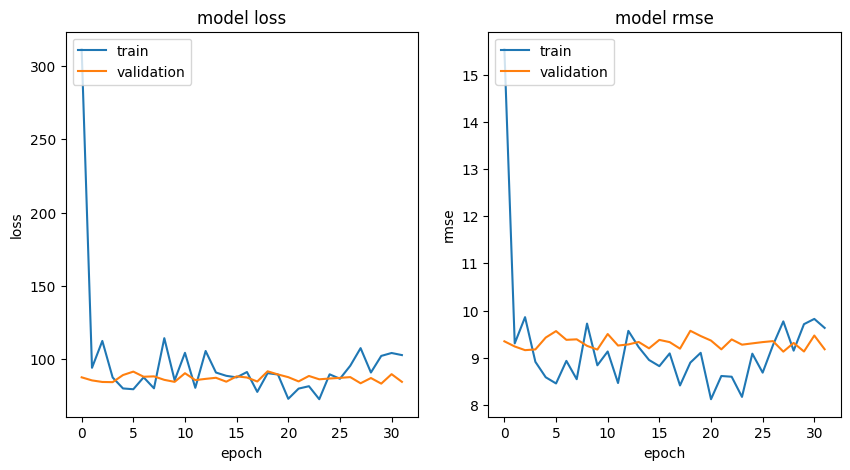

In [12]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Lab Task 5: Predict with the model locally

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the cab ride you want to predict the fare amount for.

In [13]:
# A dictionary is created where each key is the name of an input feature and each value is a TensorFlow tensor converted from a given value.
model.predict({
    # "tf.convert_to_tensor" converts the provided values to TensorFlow tensors.
    'pickup_longitude': tf.convert_to_tensor([-73.982683]), # Pickup point longitude.
    'pickup_latitude': tf.convert_to_tensor([40.742104]), # Latitude of the pickup point.
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]), # Longitude of the destination point.
    'dropoff_latitude': tf.convert_to_tensor([40.755174]), # Latitude of the destination point.
    'passenger_count': tf.convert_to_tensor([3.0]), # Number of passengers in the trip.    
}, steps=1) # The number of prediction steps. Here, steps=1 indicates that a single batch of data will be processed for prediction.


1/1 [==============================] - 0s 159ms/step


array([[-23.84274]], dtype=float32)

Of course, this is not realistic, because we can't expect client code to have a model object in memory. We'll have to export our model to a file, and expect client code to instantiate the model from that exported file.

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.